In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from IPython.display import clear_output
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from models import Encoder, Decoder, NeuroDataset
from itertools import combinations
from tqdm import tqdm_notebook
from sklearn.manifold import LocallyLinearEmbedding, Isomap, SpectralEmbedding
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd

from sklearn.multioutput import RegressorChain, MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error
from sklearn.linear_model import Ridge, Lasso
from lightgbm import LGBMRegressor
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
r2_scorer = make_scorer(r2_score)
from IPython.core.debugger import set_trace

In [2]:
def calc_gradient_magnitude(named_parameters, silence=False):
    total_amplitude = []
    for name, p in named_parameters:
        # print(name)
        if p.grad is not None:
            param_amplitude = p.grad.data.abs().max()
            total_amplitude += [param_amplitude.item()]
        elif not silence:
            print (name, 'grad is None')    

    total_amplitude = max(total_amplitude)

    return total_amplitude

# EDA

 - В кольцевом треке (circle_track) и треке с отверстиями (holy_track).    
 - В каждом из треков n= 4 мыши (CA1_22, CA1_23, CA1_24 и CA1_25) провели 3 раза по 15 минут с интервалом в 1 сутки (отсюда индексы 1D, 2D, 3D).   
 - В треке с отверстиями их число менялось от 3х в первый день до 1го в третий.  
 
Данные имеют вид .csv таблиц (разделители — запятые), в первом столбце- время в секундах, далее идут столбцы с координатами центра масс мыши (x,y), затем координаты цветных маркеров на голове мыши (x_green, y_green, x_red, y_red; расположены как на рисунке в приложениии);   
Они есть только для кольцевого трека и фиксируются камерой не очень надёжно, так что в некоторых местах имеют разрывы — я старался их очистить, насколько это возможно, но не всё удалось отфильтровать, к сожалению.   

Координаты даны в пикселях, диаметр трека равен 50 см. После координат маркеров следуют столбцы с собственно нейронной активностью (т.е. интенсивностью флуоресценции;  данные получены путём применения алгоритма CNMF-E) для каждой из клеток.  
 
Для кольцевого трека есть аналогичные «сырым» данным нейронной активности данные по дискретным активациям каждой из клеток  — они состоят из амплитуд значимых (>4 MAD) событий в местах, где они происходят и нулей во всех остальных точках (по формату всё то же, что и с «сырыми» данными, только без координат). 

![sdf](./mouse_setup.png)

In [3]:
spikes_df = pd.read_csv("./Data_Calcium/Circle/CA1_22_1D_initial_data.csv", index_col=0)
spikes_events_df = pd.read_csv("./Data_Calcium/Circle/CA1_22_1D_initial_data_spikes.csv", index_col=0)
print('n_steps', 'n_electrodes', spikes_df.shape)
trim=50
spikes_df = spikes_df[trim:-trim]

n_steps n_electrodes (18775, 556)


In [4]:
X = spikes_df.iloc[:,7:].to_numpy()
X_std = StandardScaler().fit_transform(X)
N = X.shape[0]

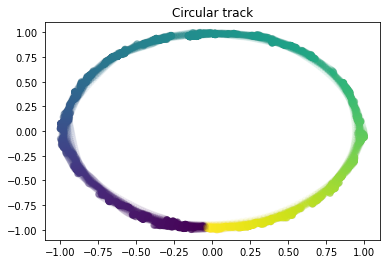

In [5]:
coords = spikes_df[['x', 'y']].values
coords -= coords.mean(0)[None,:]
phi = np.arctan2(coords[:,0], coords[:,1])

minmax_scaler = MinMaxScaler((-1,1))
coords_ = minmax_scaler.fit_transform(coords)

plt.title("Circular track")

plt.scatter(coords_[:,0], coords_[:,1], alpha=0.05, c=phi)
plt.show()

# Choosing intrinsic dim

In [6]:
# from manifold_utils import repeated, intrinsic_dim_scale_interval

# n_samples = X_std.shape[0]
# k1 = 10 #min(10, n_samples//20)
# k2 = 150 #min(100, n_samples//4)

# intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
#                              X_std, 
#                              mode='bootstrap', 
#                              nb_iter=8,
#                              k1=k1, 
#                              k2=k2,
#                              step=10)
# intdim_k_repeated = np.array(intdim_k_repeated)

In [7]:
# neighbors = np.arange(k1, k2, 5)

# fig = plt.figure(figsize=(12,5.25))

# floor_n_ceil = np.concatenate((np.floor(np.mean(intdim_k_repeated, axis=0)).astype(int), 
#                                 np.ceil(np.mean(intdim_k_repeated, axis=0)).astype(int)))

# plt.subplot(121)
# plt.xlabel("Neighborhood cardinality")
# plt.ylabel("Intrinsic dimension")
# plt.grid(linestyle='dotted')

# plt.plot(np.arange(intdim_k_repeated.shape[1]) * 5 + 10, np.mean(intdim_k_repeated, axis=0), 'b')
# plt.plot(np.arange(intdim_k_repeated.shape[1]) * 5 + 10, np.mean(intdim_k_repeated, axis=0) + np.std(intdim_k_repeated, axis=0), 'r')
# plt.plot(np.arange(intdim_k_repeated.shape[1]) * 5 + 10, np.mean(intdim_k_repeated, axis=0) - np.std(intdim_k_repeated, axis=0), 'r')

# plt.subplot(122)
# plt.xlabel("Intrinsic dimension")
# plt.grid(linestyle="dotted")

# plt.hist(intdim_k_repeated.mean(axis=0))
# plt.show()

# Models

In [8]:
class AE(nn.Module):

    def __init__(self, orig_dim, inter_dim, code_dim, **kwargs):
        super().__init__()
        
        self.encoder = nn.Sequential(nn.Linear(orig_dim, inter_dim),
                                    nn.LeakyReLU(),
                                    nn.BatchNorm1d(inter_dim),
                                    nn.Linear(inter_dim, inter_dim),
                                    nn.LeakyReLU(),
                                    nn.BatchNorm1d(inter_dim),
                                    nn.Linear(inter_dim, inter_dim),
                                    nn.LeakyReLU(),
                                    nn.BatchNorm1d(inter_dim),
                                    nn.Linear(inter_dim, code_dim))
        
        self.decoder = nn.Sequential(nn.Linear(code_dim, inter_dim),
                                    nn.LeakyReLU(),
                                    nn.BatchNorm1d(inter_dim),
                                    nn.Linear(inter_dim, inter_dim),
                                    nn.LeakyReLU(),
                                    nn.BatchNorm1d(inter_dim),
                                    nn.Linear(inter_dim, inter_dim),
                                    nn.LeakyReLU(),
                                    nn.BatchNorm1d(inter_dim),
                                    nn.Linear(inter_dim, orig_dim))
    
    def forward(self, features):
        code = self.encoder.forward(features)
        reconstructed = self.decoder.forward(code)
        return reconstructed, code

    def get_code_embedding(self, data):
        embedding = Encoder.forward(data)
        return embedding.detach().numpy()

In [9]:
class VAE(nn.Module):
    def __init__(self, orig_dim, inter_dim, code_dim, use_pxz_dist=False, **kwargs):
        super(VAE, self).__init__()
        self.use_pxz_dist = use_pxz_dist
        
        self.output_dim = 2*orig_dim if self.use_pxz_dist else orig_dim
        
        self.encoder = nn.Sequential(nn.Linear(orig_dim, inter_dim),
                                    nn.LeakyReLU(),
                                    nn.Linear(inter_dim, inter_dim),
                                    nn.LeakyReLU(),
                                    nn.Linear(inter_dim, 2*code_dim))
        
        self.decoder = nn.Sequential(nn.Linear(code_dim, inter_dim),
                                    nn.LeakyReLU(),
                                    nn.Linear(inter_dim, inter_dim),
                                    nn.LeakyReLU(),
                                    nn.Linear(inter_dim, self.output_dim))
        
        self.orig_dim = orig_dim
        self.inter_dim = inter_dim
        self.code_dim = code_dim
        
    def reparameterization(self, mu, logsigma):
        """
        :param mu: mean from the encoder's latent space
        :param logsigma: log sigma from the encoder's latent space
        """
        std = torch.exp(logsigma) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
    
    def get_code(self, features):
        x = self.encoder.forward(features)
        
        #print('x shape:', x.shape)
        x = x.view(-1, 2, self.code_dim)

        # get `mu` and `logsigma`
        mu = x[:, 0, :] # the first feature values as mean
        logsigma = x[:, 1, :] # the other feature values as squared root of variance
        
        if model.training:
            # get the latent vector through reparameterization
            code = self.reparameterization(mu, logsigma)
        else:
            code = mu

        return code, mu, logsigma
        
    def forward(self, features):
        # encoding
        code, mu_z, logsigma_z = self.get_code(features)

        # decoding
        reconstruction_params = self.decoder(code)
        if self.use_pxz_dist:
            reconstruction_params = reconstruction_params.view(-1, 2, self.orig_dim)
            mu_gen = reconstruction_params[:, 0, :]
            logsigma_gen = reconstruction_params[:, 1, :]
        else:
            mu_gen = reconstruction_params
            logsigma_gen = None
        return mu_gen, logsigma_gen, mu_z, logsigma_z
    
    def get_code_embedding(self, dataset):
        Encoder = self.encoder
        input = torch.tensor(dataset.data).float()
        embedding, mu, logsigma = self.get_code(input)

        return embedding.detach().numpy().T

In [10]:
def validate(model, val_loader, loss_type, use_targets, targets_loss_weight, plot=False):
    model.eval()
    history = defaultdict(list)
    with torch.no_grad():
        for itr, data in enumerate(val_loader):   
            
            if use_targets:
                targets = data[1]
                data = data[0]
                targets = torch.stack(targets, dim=1)
            
            if model.__class__.__name__ == 'AE':
                mu_gen, mu_z = model(data)
            elif model.__class__.__name__ == 'VAE':
                mu_gen, logsigma_gen, mu_z, logsigma_z = model(data)
            else: 
                raise RuntimeError()
    
            if loss_type == 'mse':
                train_loss = criterion(mu_gen, data)
                kld_loss, loss = torch.tensor(0), torch.tensor(0)
                if model.__class__.__name__ == 'VAE':
                    kld_loss = KL_divergence(mu_z, logsigma_z)
                    train_loss = loss + kld_loss.sum()
            elif loss_type == 'nll':
                train_loss, kld_loss, loss = loss_vae(data, mu_gen, logsigma_gen, mu_z, logsigma_z)
            elif loss_type == 'bce':
                loss = F.binary_cross_entropy(mu_gen, data, reduction='sum')
                kld_loss = KL_divergence(mu_z, logsigma_z)
                train_loss = loss + kld_loss.sum()
            else:
                raise RuntimeError()
                
            if use_targets:
                n_targets = targets.shape[1]
                target_loss = ((mu_z[:,:n_targets] - targets).abs()).mean(0)
                train_loss += target_loss.mean() * targets_loss_weight
            
            MAE = torch.norm(data - mu_gen, p=1, dim=1) / torch.norm(data, p=1, dim=1)
            MAE = MAE.mean()

            history['total_loss'].append(train_loss.item())
            history[f'{loss_type}_loss'].append(loss.item())
            history['kld_loss'].append(kld_loss.sum().item())
            history['MAE'].append(MAE.item())
            if use_targets:
                for i, target_name in enumerate(val_loader.dataset.targets_names):
                    history[f'{target_name}_loss'].append(target_loss[i].item())
            
    history = {k:np.mean(v) for k,v in history.items()}
    
    if plot:
        fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15,10))
        for i,ax in enumerate(axes.flatten()):
            ax.plot(data[i].detach().cpu().numpy(), label='original', alpha=0.6)
            ax.plot(mu_gen[i].detach().cpu().numpy(), label='generated', alpha=0.6)
        plt.legend()
        plt.show()
    
    return history

In [11]:
class MultipleTargetDataset(Dataset):
    def __init__(self, X_tensor, target_dict):
        super().__init__()
        self.X = X_tensor
        self.target_dict = target_dict
        self.targets_names = list(target_dict.keys())
        
    def __getitem__(self,i):
        return self.X[i], [v[i] for k,v in self.target_dict.items()]
    
    def __len__(self):
        return len(self.X)

In [12]:
sqrt2pi = torch.tensor(np.sqrt(2*np.pi))
EPS = 1e-10

def KL_divergence(mu, logsigma):
    return -0.5*(1 + 2*logsigma - mu.pow(2) - logsigma.exp().pow(2))

def log_likelihood(x, mu, logsigma):
    return -(((mu - x).pow(2) / (2*logsigma.exp().pow(2) + EPS)) + logsigma + sqrt2pi.log()).sum()

def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    kl_div = KL_divergence(mu_z, logsigma_z)
    nll = -log_likelihood(x, mu_gen, logsigma_gen)
    return (kl_div.sum() + nll) / x.numel() , kl_div, nll


$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$


$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)= - \sum_{i=1}^{dimX} (\frac{(\mu_I-x)^2}{2\sigma_i^2} + log(\sigma_i)  + log(\sqrt{2\pi})) $$


# AE/VAE Model

In [13]:
def train_autoencoder(model, 
                      optimizer, 
                      train_loader, 
                      val_loader, 
                      epochs, 
                      plot,
                      denoising,
                      denoising_weight,
                      use_targets,
                      targets_loss_weight):
    
    history_train = defaultdict(list)
    history_val = defaultdict(list)
    history_train_epoch = defaultdict(list)

    iterator = range(epochs) if plot else tqdm_notebook(range(epochs)) 
    for epoch in iterator:
        model.train()
        for itr, data in enumerate(train_loader):       
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()
            
            if use_targets:
                targets = data[1]
                data = data[0]
                targets = torch.stack(targets, dim=1)

            if denoising:
                data = data + denoising_weight*torch.randn_like(data).cuda()

            with torch.autograd.detect_anomaly():
                # compute training reconstruction loss
                if model.__class__.__name__ == 'AE':
                    mu_gen, mu_z = model(data)
                elif model.__class__.__name__ == 'VAE':
                    mu_gen, logsigma_gen, mu_z, logsigma_z = model(data)
                else: 
                    raise RuntimeError()

                if loss_type == 'mse':
                    train_loss = criterion(data, mu_gen)
                    kld_loss, loss = torch.tensor(0), torch.tensor(0)
                    if model.__class__.__name__ == 'VAE':
                        kld_loss = KL_divergence(mu_z, logsigma_z)
                        train_loss = train_loss + kld_loss.sum()
                elif loss_type == 'nll':
                    train_loss, kld_loss, loss = loss_vae(data, mu_gen, logsigma_gen, mu_z, logsigma_z)
                elif loss_type == 'bce':
                    loss = F.binary_cross_entropy(mu_gen, data, reduction='sum')
                    kld_loss = KL_divergence(mu_z, logsigma_z)
                    train_loss = loss + kld_loss
                else:
                    raise RuntimeError()
                
                if use_targets:
                    n_targets = targets.shape[1]
                    target_loss = ((mu_z[:,:n_targets] - targets).abs()).mean(0)
                    train_loss += target_loss.mean() * targets_loss_weight
                
                # compute accumulated gradients
                train_loss.backward()

                # metrics
                if clip_grads:
                    MAX_GRAD = 1
                    torch.nn.utils.clip_grad_value_(model.parameters(), MAX_GRAD)
                    assert max([param.grad.abs().max().item() for param in model.parameters()]) <= MAX_GRAD

                grad_magnitude = calc_gradient_magnitude(filter(lambda x: x[1].requires_grad, \
                                                                      model.named_parameters()), silence=False)
                MAE = torch.norm(data - mu_gen, p=1, dim=1) / torch.norm(data, p=1, dim=1)
                MAE = MAE.mean()

                # perform parameter update based on current gradients
                optimizer.step()

            history_train['total_loss'].append(train_loss.item())
            history_train[f'{loss_type}_loss'].append(loss.item())
            history_train['kld_loss'].append(kld_loss.sum().item())
            history_train['MAE'].append(MAE.item())
            history_train['grad_magnitude'].append(grad_magnitude)
            if use_targets:
                for i, target_name in enumerate(train_loader.dataset.targets_names):
                    history_train[f'{target_name}_loss'].append(target_loss[i].item())

            if (itr%500) == 0 and plot:
                clear_output(wait=True)
                fig, axes = plt.subplots(ncols=5, nrows=3 if use_targets else 2, figsize=(50,20))

                #--------TRAIN
                axes[0,0].plot(history_train['total_loss'])
                axes[0,0].set_title(f'Total loss iter')

                axes[0,1].plot(history_train[f'{loss_type}_loss'])
                axes[0,1].set_title(f'{loss_type} loss iter')

                axes[0,2].plot(history_train['kld_loss'])
                axes[0,2].set_title(f'KLD loss iter')

                axes[0,3].plot(history_train['grad_magnitude'])
                axes[0,3].set_title(f'grad magnitude iter')

                axes[0,4].plot(history_train['MAE'])
                axes[0,4].set_title(f'MAE iter')

                #----------EPOCH

                axes[1,0].plot(history_train_epoch['total_loss'], label='train')
                axes[1,0].plot(history_val['total_loss'], label='val')
                axes[1,0].set_title(f'Total loss epoch')

                axes[1,1].plot(history_train_epoch[f'{loss_type}_loss'], label='train')
                axes[1,1].plot(history_val[f'{loss_type}_loss'], label='val')
                axes[1,1].set_title(f'{loss_type} epoch')

                axes[1,2].plot(history_train_epoch['kld_loss'], label='train')
                axes[1,2].plot(history_val['kld_loss'], label='val')
                axes[1,2].set_title(f'KLD epoch')

                axes[1,3].plot(history_train_epoch['grad_magnitude'], label='train')
                axes[1,3].set_title(f'grad magnitude epoch')

                axes[1,4].plot(history_train_epoch['MAE'], label='train')
                axes[1,4].plot(history_val['MAE'], label='val')
                axes[1,4].set_title(f'MAE epoch')
                
                if use_targets:
                    for k,target_name in enumerate(train_loader.dataset.targets_names):
                        axes[2,k].plot(history_train_epoch[f'{target_name}_loss'], label='train')
                        axes[2,k].plot(history_val[f'{target_name}_loss'], label='val')
                        axes[2,k].set_title(f'{target_name} loss epoch')

                plt.legend()
                plt.tight_layout()
                plt.show()
                
                if model.__class__.__name__ == 'VAE':
                    plt.figure()
                    plt.bar(np.arange(code_dim),
                            kld_loss.mean(0).detach().cpu().numpy())
                    plt.title('KLD(q(z|x)||N(0,I)) by components')
                    plt.ylabel('KL-divergence')
                    plt.xlabel('Code_dim cordinate')
                    plt.show()

        # END of the epoch
        for k in history_train.keys():
            history_train_epoch[k].append(np.mean(history_train[k][-len(train_loader):]))
            
        history_val_item = validate(model, val_loader, loss_type, use_targets, targets_loss_weight)
        for k,v in history_val_item.items():
            history_val[k].append(v)
    return model, history_train, history_val

# Data

In [14]:
indexes_targets = np.arange(N)
np.random.shuffle(indexes_targets)

# speed sign
dphi = phi - np.concatenate([phi[0:1],phi[:-1]], axis=0)
dphi[dphi > 6] = -dphi[dphi > 6]
circle_sign = np.sign(dphi)

# speed
shift = coords_ - np.concatenate([coords_[0:1,:],coords_[:-1,:]], axis=0)
speed = (shift**2).sum(1) * circle_sign

# acceleration
speed_shift = np.concatenate(([speed[0]], speed))[:-1]
acceleration = speed - speed_shift

acceleration_ = MinMaxScaler((-1,1)).fit_transform(acceleration[:,None]).flatten()
speed_ = MinMaxScaler((-1,1)).fit_transform(speed[:,None]).flatten()

random_acceleration_ = acceleration_[indexes_targets]
random_speed_ = speed_[indexes_targets]

targets = {
    'x': coords_[:,0],
    'y': coords_[:,1],
    'v': speed_,
    'a': acceleration_
}


# targets = {
#     'x': np.random.randn(N),
#     'y': np.random.randn(N),
#     'v': np.random.randn(N),
#     'a': np.random.randn(N)
# }

In [15]:
np.random.seed = 42
torch.manual_seed(42)

orig_dim = X.shape[1]
inter_dim = 1024
epochs = 500
batch_size = 256
learning_rate = 1e-3
denoising_weight = 1e-2

torch.manual_seed(42)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

##############
# PARAMETERS #
##############
use_targets = False
targets_loss_weight = 1e-1
plot=True
denoising=True # use denoising AE
clip_grads=False
use_pxz_dist=False # use p(x|z) distribution as VAE output

In [16]:
N = X_std.shape[0]
indexes = np.arange(N)
np.random.shuffle(indexes)
val_ratio = 0.1
split_index = int(val_ratio*N)
val_indexes = indexes[:split_index]
train_indexes = indexes[split_index:]   

X_std_tensor = torch.from_numpy(X_std).cuda().float()

X_std_val = X_std_tensor[val_indexes]
X_std_train = X_std_tensor[train_indexes]

if use_targets:
    targets_tensors_train = {}
    targets_tensors_val = {}
    for k, v in targets.items():
        targets_tensors_train[k] = torch.from_numpy(v[train_indexes]).cuda().float()
        targets_tensors_val[k] = torch.from_numpy(v[val_indexes]).cuda().float()
    
    X_std_train = MultipleTargetDataset(X_std_train, targets_tensors_train)
    X_std_val = MultipleTargetDataset(X_std_val, targets_tensors_val)

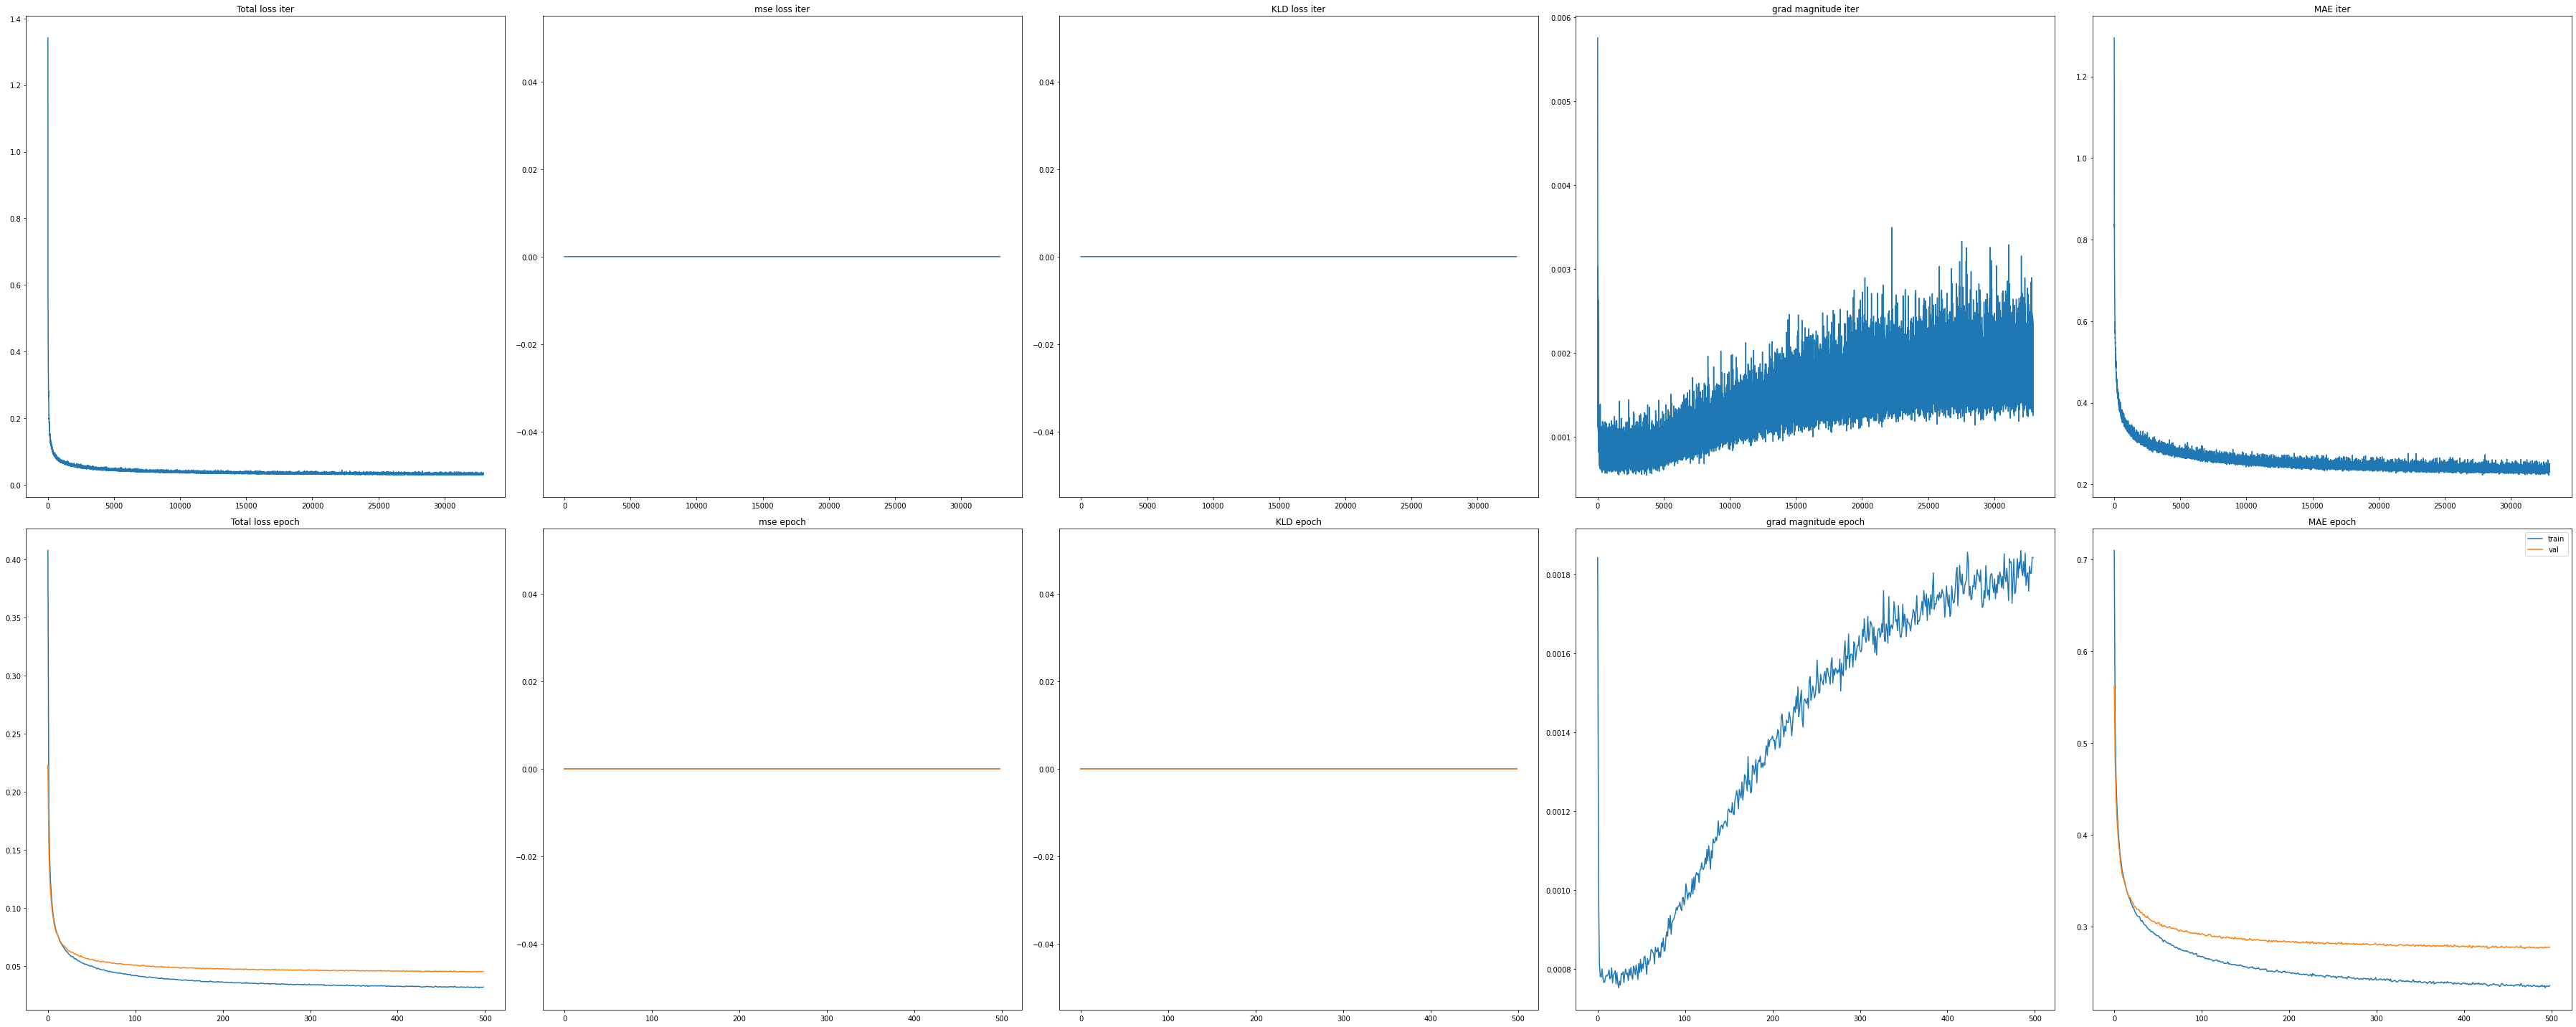

In [17]:
loss_type = 'mse'
if loss_type == 'mse':
    criterion = nn.MSELoss()
if use_pxz_dist:
    assert loss_type == 'nll' # negative log-likelihood
if loss_type == 'nll':
    assert use_pxz_dist
    

dim_results_dict = defaultdict(dict)
# ist(range(2,10,1)) + list(range(10,50,5)) + [60,80,100,200,300,400,549]    
dim_range = list(range(2,30,1))  + list(range(30,60,5)) + [60,80,100,200,300,400,549] 
for code_dim in tqdm_notebook(dim_range): 
    
    # supported types: AE/VAE    
    model_type = AE
    model_params = {
        'orig_dim':orig_dim, 
        'inter_dim':inter_dim, 
        'code_dim':code_dim, 
        'use_pxz_dist':use_pxz_dist
    }

    train_loader = DataLoader(X_std_train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(X_std_val, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model_type(**model_params).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)
    
    model, history_train, history_val = train_autoencoder(model, 
                                                          optimizer, 
                                                          train_loader, 
                                                          val_loader, 
                                                          epochs, 
                                                          plot,
                                                          denoising,
                                                          denoising_weight,
                                                          use_targets,
                                                          targets_loss_weight)
    
    embedding_val_numpy = model.encoder(X_std_val).detach().cpu().numpy() 
    embedding_train_numpy = model.encoder(X_std_train).detach().cpu().numpy() 
    
    for k,v in targets.items():
        v_train = v[train_indexes]
        v_test = v[val_indexes]
        est = LGBMRegressor(random_state=42)
        est.fit(embedding_train_numpy,v_train)
        v_pred = est.predict(embedding_val_numpy)
        
        r2 = r2_score(v_test, v_pred)
        mae = np.abs(v_test - v_pred).mean()
        
        dim_results_dict[code_dim][k] = [r2, mae]

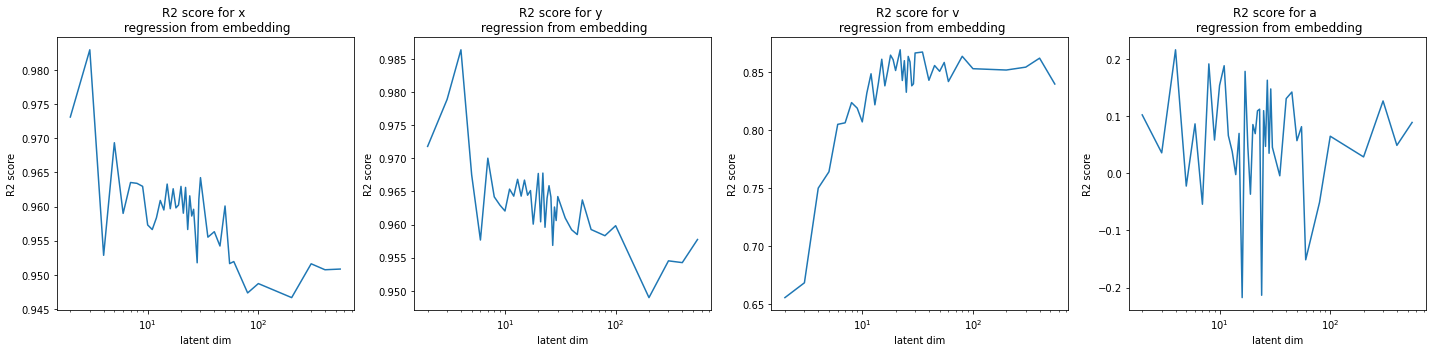

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
for k,ax in zip(targets.keys(),axes.flatten()):
    ax.plot(dim_range, [item[k][0] for _,item in dim_results_dict.items()])
    ax.set_title(f'R2 score for {k} \n regression from embedding')
    ax.set_xlabel('latent dim')
    ax.set_ylabel('R2 score')    
    ax.semilogx()
plt.tight_layout()
plt.show()

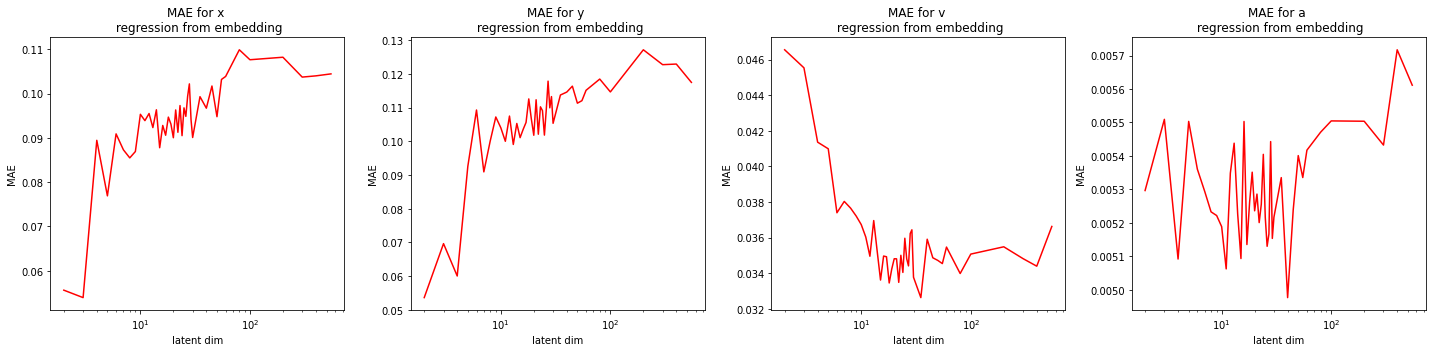

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
for k,ax in zip(targets.keys(),axes.flatten()):
    ax.plot(dim_range, [item[k][1] for _,item in dim_results_dict.items()], 'r')
    ax.set_title(f'MAE for {k} \n regression from embedding')
    ax.set_xlabel('latent dim')
    ax.set_ylabel('MAE')    
    ax.semilogx()
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
for k,ax in zip(targets.keys(),axes.flatten()):
    ax.plot(dim_range, [item[k][0] for _,item in dim_results_dict.items()])
    ax.set_title(f'R2 score for {k}')
    ax.set_xlabel('latent dim')
    ax.set_ylabel('R2 score')    
plt.tight_layout()
plt.show()

In [18]:
# embedding = model.encoder(X_std_tensor)
# embedding_numpy = embedding.detach().cpu().numpy() 
# # dim_results_dict[code_dim] = [history_train, history_val]
# embedding_name = f'AE{inter_dim}_dim-{code_dim}_ep-{epochs}' + ('denoise-' + str(denoising_weight) if denoising else '') + '_MSE' + '_TARGETS-xyva-signed'
# # np.save(os.path.join('./embeddings',embedding_name), embedding_numpy)

In [19]:
# dims_combinations = list(combinations(np.arange(len(targets)), 2))
# n_vis = np.floor(np.sqrt(len(dims_combinations))).astype(int)

# fig, axes = plt.subplots(ncols=n_vis, nrows=n_vis, figsize=(n_vis*5,n_vis*5))
# for i, ax in enumerate(axes.flatten()):
#     d1,d2 = dims_combinations[i]
#     ax.scatter(embedding_numpy[:,d1], embedding_numpy[:,d2], alpha=0.1, c=phi)
#     ax.set_title(f'DIMS: {d1},{d2}')
# plt.tight_layout()

In [20]:
# plt.scatter(embedding_numpy[:,2], embedding_numpy[:,3], alpha=0.1, c=targets['v'])
# plt.title(f'DIMS: {2},{3}')
# plt.show()

In [21]:
# if model.__class__.__name__ == 'VAE':
#     for itr, data in enumerate(val_loader):  
#         data = data.float().cuda()
#         mu_gen, logsigma_gen, mu_z, logsigma_z = model(data)
#         train_loss, kld_loss, loss = loss_vae(data, mu_gen, logsigma_gen, mu_z, logsigma_z)

#         l1 = model.decoder[0]
#         l1_weights = l1.weight.norm(dim=0).detach().cpu().numpy()
#         nonzero_components_mask = (kld_loss.mean(0) > 0.5).detach().cpu().numpy()

#         plt.figure(figsize=(15,10))
#         plt.bar(np.arange(code_dim),
#                 kld_loss.mean(0).detach().cpu().numpy(),
#                 alpha=0.5,
#                 label='KL-divergence')
#         plt.bar(np.arange(code_dim),
#                 l1_weights,
#                 color='r',
#                 alpha=0.2,
#                 label='decoder 1st layer weights norm')
#         plt.title(r'$KLD(q(z|x) || N(0,I))$ by components')
#         plt.ylabel(f'Non-zero components: {nonzero_components_mask.sum()}')
#         plt.xlabel('Code_dim cordinate')
#         plt.show()

#         break

In [22]:
# embedding = model.encoder(X_std_tensor)
# embedding = embedding.view(-1, 2, code_dim)
# embedding = embedding[:, 0, :] # the first feature values as mean
# embedding_numpy = embedding.detach().cpu().numpy()

In [23]:
# nonzero_components_mask = (kld_loss.mean(0) > 0.5).detach().cpu().numpy()
# n_nonzero_components = nonzero_components_mask.sum()
# embedding_numpy_chosen = embedding_numpy[:,nonzero_components_mask]

In [24]:
# dims_combinations = list(combinations(np.arange(n_nonzero_components), 2))
# n_vis = np.floor(np.sqrt(len(dims_combinations))).astype(int)

# fig, axes = plt.subplots(ncols=n_vis, nrows=n_vis, figsize=(n_vis*5,n_vis*5))
# for i, ax in enumerate(axes.flatten()):
#     d1,d2 = dims_combinations[i]
#     ax.scatter(embedding_numpy_chosen[:,d1], embedding_numpy_chosen[:,d2], alpha=0.1, c=phi)
#     ax.set_title(f'DIMS: {d1},{d2}')
# plt.tight_layout()

In [25]:
# plt.plot(dim_range, [min(dim_results_dict[d][1]['MAE']) for d in dim_range])
# plt.xlabel('code dim')
# plt.xlabel('MAE') 
# plt.title('Reconstruction Val MAE, normalized')
# plt.show()

In [26]:
# maes = [min(dim_results_dict[d][1]['MAE']) for d in dim_range][:10]
# plt.plot(dim_range[:10], maes)
# plt.vlines([3,6], ymin=min(maes), ymax=max(maes),colors=['r','r'])
# plt.xlabel('code dim')
# plt.xlabel('MAE')
# plt.title('Reconstruction Val MAE, normalized')

# Calculate embeddings

In [27]:
# X_std_tensor = torch.from_numpy(X_std).cuda().float()
# if model.__class__.__name__ == 'AE':
#     embedding = model.encoder(X_std_tensor)
# elif model.__class__.__name__ == 'VAE':
#     _, embedding, _ = model.get_code(X_std_tensor)
# embedding_numpy = embedding.detach().cpu().numpy()

In [28]:
# embedding_name = f'AE{inter_dim}_dim-{code_dim}_ep-{epochs}' + ('denoise-' + str(denoising_weight) if denoising else '') + '_MSE'
# np.save(os.path.join('./embeddings',embedding_name), embedding_numpy)

# Plot results

In [29]:
# embedding_numpy = np.load('./embeddings/AE512_dim-6_ep-500denoise-0.01_MSE.npy')

In [30]:
# code_dim = embedding_numpy.shape[1]
# dims_combinations = list(combinations(np.arange(code_dim), 2))
# n_vis = np.floor(np.sqrt(len(dims_combinations))).astype(int)

# fig, axes = plt.subplots(ncols=n_vis, nrows=n_vis, figsize=(n_vis*5,n_vis*5))
# for i, ax in enumerate(axes.flatten()):
#     d1,d2 = dims_combinations[i]
#     ax.scatter(embedding_numpy[:,d1], embedding_numpy[:,d2], alpha=0.1, c=phi)
#     ax.set_title(f'DIMS: {d1},{d2}')
#     fig.suptitle(f'AE embeddings projections for latent_dim {code_dim}', fontsize=20, color='b')
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# # plt.tight_layout()

# Conditional AE

# Manifold Learning (to compare with AE results)

In [31]:
# from sklearn.preprocessing import StandardScaler
# d_scaled = StandardScaler().fit_transform(d.T)
# lem = SpectralEmbedding(n_components=10, n_neighbors=150)
# lem_emb = lem.fit_transform(d_scaled)

### dims_combinations = list(combinations(np.arange(10), 2))
# n_vis = np.floor(np.sqrt(len(dims_combinations))).astype(int)

# fig, axes = plt.subplots(ncols=n_vis, nrows=n_vis, figsize=(n_vis*5,n_vis*5))
# for i, ax in enumerate(axes.flatten()):
#     d1,d2 = dims_combinations[i]
#     ax.scatter(lem_emb[:,d1], lem_emb[:,d2], alpha=0.1, c=phi)
#     ax.set_title(f'DIMS: {d1},{d2}')
# plt.tight_layout()